# Plane Boarding Simulation

#### Prerequisites

The project was created and tested using Python 3.7\
Additionally the renderer requires Pygame module installed.

This document was created in Jupyter Notebook using matplotlib and numpy modules.\
It was then exported as HTML for easier access without this software.

### Simulation architecture description

The central part of the program is the `run` function from the `runner` module. Given the variable parameters at the input together with static parameters from `parameters` module it orchestrates the whole simulation. It's responsible for maintaning `execution_queue` heap for agents' actions as well as the `board` 2d list which provides agents with the information about their neighbourhood.
The function `run` is a `generator`. That means we can easily iterate over values yielded by it. In this case generated values are sequential changes made by the agents. This behaviour is used in the module responsible for rendering. Even though it's separated from the rest of the code, it operates lazily. The strict renderer - on the other hand - would have to first generate all the data and only then it would be able to display it.

The inner workings of the `run` function can be roughly described as follows:
0. initialize `execution_queue` and `board` using `initialize` function to get state appropriate to the specified parameters (like `boarding_method`)
1. yield all the agents' states
2. loop until `execution_queue` is empty or tick limit exceeded:
    0. take one agent from it
    1. make the agent conduct next action using the `act` method and the current context
    2. put agent back into the queue unless it wont take action anymore
    3. yield agent's new state


To make the method `act` work, each agent maintains its current state. It consists mainly of the `target`, `coords` and `state` fields. Based on these as well as its neighbourhood (obtained from `board`), each agent when `act`ed on, can `move` or change its `state`.

The major `state`s are:
0. `go` - responsible for moving towards the seat
1. `luggage` - responsible for bag stowing
2. `waiting` - responsible for noticing agents that need to be let in
3. `shuffle_*` - responsible for the shuffles
4. `done` - agent won't activate anymore; it has no other `act`ion to take

### The simulation parameters and running

Most of the simulation parameters are stored in the `parameters` module. Some of them can be easily tweaked or modified. The more experimental ones are generally marked as such.

The parameters that were needed to succesfully run batches with are directly passed to the `run` function instead.

On the other hand I had to explicitly assume some of the simulation conditions. For example the time taken by the agent to walk between tiles is set to 5 ticks. The luggage stowing time is set to 10 ticks on average with the standard deviation of $\frac{4}{3}$. Also, there is set a limit of 2500 (default) ticks, that if exceeded terminates the simulation.

The renderer parameters can be changed as well. For example to speed up rendering of the simulation, the `display_framerate` can be set to a higher value. To watch the simulation one just need to run `python3 ./renderer1.py`. By default it will run all boarding methods in order.

### Efficiency of  different boarding strategies

In [1]:
import matplotlib.pyplot as plt
import numpy
import statistics
import pickle

In [2]:
with open("./pickle_dumps/batch_methods_500_664078.pkl", 'rb') as f:
    batch_methods = pickle.load(f)

The timing data is generated by the `batch_runner` module and pickled into the `.pkl` files.
Then they can be read by the preceding code and plotted as a nice graph.

(provided files contain 500 - or 1000 - data points for each boarding strategy or parameters choice)

The `batch_runner` module first asks the user for the number of samples to gather and then for the desired process count to enable parallel execution - thus accelerating the computation on multi-core machines.

random_order:        μ=1350.26, σ=67.89
back_to_front:       μ=1361.65, σ=14.77
front_to_back:       μ=1602.62, σ=14.91
back_to_front_four:  μ=1676.45, σ=84.32
front_to_back_four:  μ=1902.13, σ=89.25
window_middle_aisle: μ=1001.92, σ=27.52
steffen_perfect:     μ= 817.79, σ= 6.43
steffen_modified:    μ= 982.25, σ=11.71


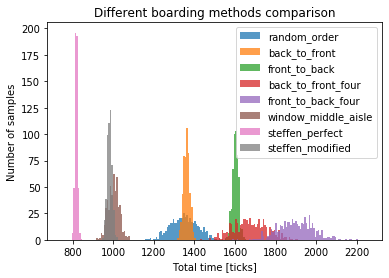

In [3]:
bins = numpy.linspace(750, 2250, 200)

text_shift = len(max(batch_methods.keys(), key=len))+1

for boarding_method, times in batch_methods.items():
    times = [t for t in times if t is not None]
    plt.hist(times, bins=bins, alpha=0.75, label=boarding_method)
    
    μ = statistics.mean(times)
    σ = statistics.stdev(times)
    
    print(f"{boarding_method+':':<{text_shift}} μ={μ:>7.2f}, σ={σ:>5.2f}")

plt.title("Different boarding methods comparison")
plt.xlabel("Total time [ticks]")
plt.ylabel("Number of samples")
plt.legend(loc='upper right')
plt.show()

Given such parameters, the quickest (μ=817.79) boarding method is `steffen_perfect`. A bit behind it, we can find both `steffen_modified` and `window_middle_aisle` whose times almost tie (μ=1001.92, μ=982.25 respectively) but spread is noticeably different: `steffen_modified` takes narrow range (σ=11.71) while `window_middle_aisle`'s standard deviation is more than twice the former (σ=27.52).\
Another pair close in average is `back_to_front` and `random_order`. In this case the difference in standard deviation is even larger (σ=14.77 compared to σ=67.89). Similar situation occurs for `front_to_back` and `back_to_front_four`. The least performing boarding method is `front_to_back_four` (μ=1902.13).\
The key difference between the `*_four` and not-`*_four` methods is the presence of shuffles. Since the order in the first ones was defined as 'random inside a group', the timing for them is inherently distributed over a distance. On the other hand, `front_to_back` and `back_to_front` were indicated as non-random - each passenger should be in a seperate group. Since the boarding order inside the row (w-m-a, a-m-w or any other) was not specified, I assumed the simplest possible: from window to the aisle. This results in no shuffles whatsoever, which can be clearly seen in the chart.\
Additionally we can easily observe, that going from back to the front is quicker than the other way around - no matter if in groups or not.

Some of the methods produce highly concentrated results while others seem to be much more random. In fact, that's exectly the case: for example `steffen_perfect` (σ=6.43 only) has no shuffling (so no randomness from here), the stowing time is almost negligible - it slows down next agents only at the very front of the plane, and remaining unpredictability comes only from randomized execution during a single frame.\
`steffen_modified` is quite similar (σ=11.71), but increases the effects of stowing - it requires more than two thirds of all agents to wait for else's luggage. Identical influence can be found among `back_to_front` (σ=14.77) and `front_to_back` (σ=14.91) - they also do not introduce any seat shuffling.\
Interestingly, the `window_middle_aisle` standard deviation (σ=27.52) is noticably higher. It could be explained as a result of initial randomness. Even though it does not cause any shuffles, it does increase time wasted by stowing - introduces great amount of unnecessary waiting for preceding agents.\
The most distributed results are - unsurprisingly - for the random methods. I.e. `random_order` (σ=67.89), `back_to_front_four` (σ=84.32) and `front_to_back_four` (σ=89.25). They all introduce shuffles (by the means of random initial setup) and do cause a lot of stowing time - since they are not specifically designed to not do so.

At the end, I would like to point out one crucial thing: the shuffles themselves do not cause much randomness, but they can and will amplify it - if and only if beeing distributed randomly themselves.

### Seat shuffles and bag stowings impact visualization

In [4]:
with open("./pickle_dumps/batch_comparison_500_664078.pkl", 'rb') as f:
    batch_comparison = pickle.load(f)

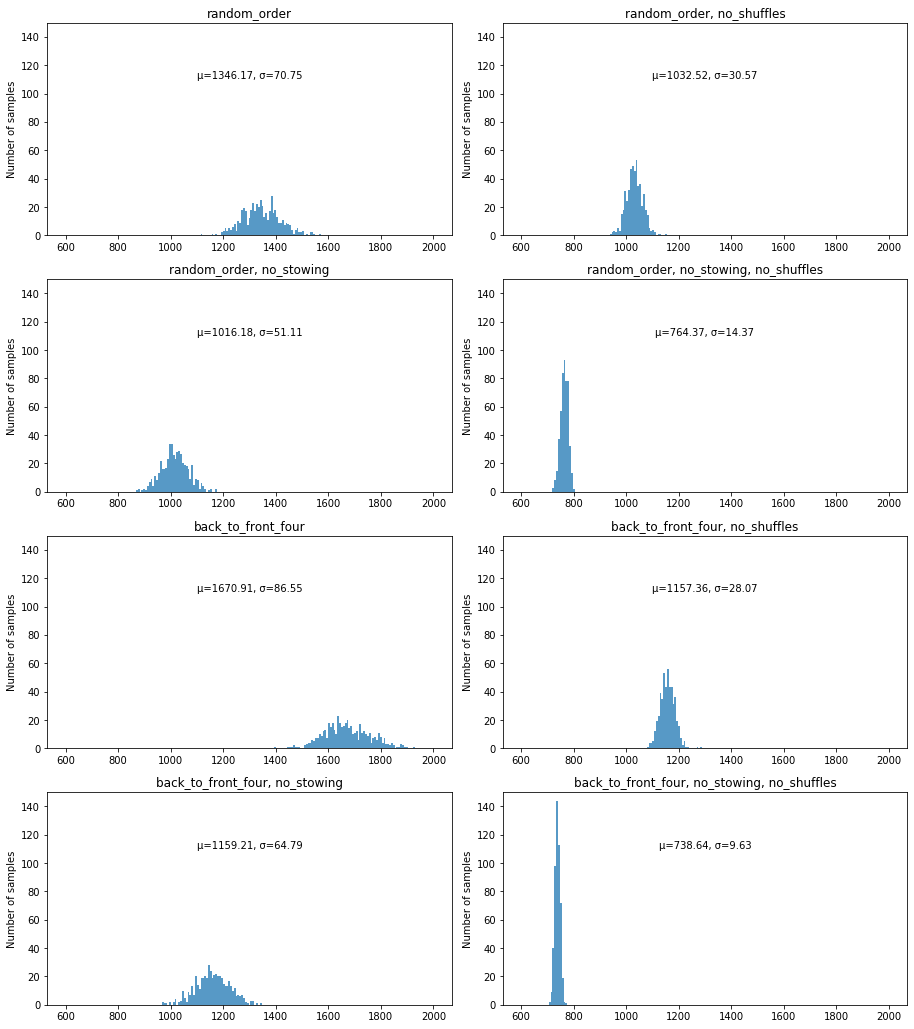

In [5]:
bins = numpy.linspace(600, 2000, 200)
top = 150

fig = plt.figure(figsize=(6.4*2, 4.8*3))

for i, (bmt, timesss) in enumerate(batch_comparison.items()):
    for j, (nsh, timess) in enumerate(timesss.items()):
        for k, (nst, times) in enumerate(timess.items()):
            ax = plt.subplot(4, 2, (4*i + 1*j + 2*k + 1))
            
            times = [t for t in times if t is not None]
            ax.hist(times, bins=bins, alpha=0.75)
            ax.set_ylim(top=top)
            
            μ = statistics.mean(times)
            σ = statistics.stdev(times)
            ax.text(0.5, 0.75, f"μ={μ:.2f}, σ={σ:.2f}",
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes)

            ax.set_title(bmt + (", no_stowing" if nst else "") + (", no_shuffles" if nsh else ""))
            # ax.set_xlabel('')
            ax.set_ylabel("Number of samples")

fig.tight_layout()
plt.show()

I have chosen ot present the data on separate sheets because I suspected that they will tend to overlap and be unreadable.

NOTE: We cannot realy compare these charts with the previous one. Looking at the raw numerical data is of course perfectly valid, but because of diferent bin size used, the shape of these plots and sample counts are scaled to different values.

### Impact of the seat shuffling and bag stowing on the boarding duration

To my surprise, the parameters chosen beforehand resulted in almost identical performance for either `no_shuffling` or `no_stowing` options enabled.

Originally I expected the stowing to have indeed greater impact than shuffling, but I suspected it to be highly dependent on the specified parameters. Important settings that I've used are:
* unit walking time - I've chosen it to be 5 ticks. Its change should not matter much - will primarily scale all the durations.
* average stowing time - I've set it to 10 ticks. It seemed resonable, as it allows wider range of possible values, without going below zero (so the abs will be rather negligible). Additionaly it is clearly higher than time required for walking a unit distance.

Additionally there's a waiting tick count, which is used to schedule next execution if no action was taken by the agent. Originally it was set to 1, to ensure fastest reaction time possible. If set to 0, should result in no delays at all - if an agent was blocked and couldn't move during said frame, it can try again immediately. Such quantity could also be interpreted as a 'reflex' parameter - the lower it is set, the more agile agents are.\
I have chosen it to be equal 2 ticks. Mainly because it decreases cpu usage almost by half, while can be perfectly justified and has a meaningful interpretation (if an agent is already walking it continues to move seamlesly, but if it has to stop then starting again is not that easy or quick).

For both `random_order` and `back_to_front_four` their default performance is generally quite spread (described in details previously) and rather slow (also described previously).\
Even though each tweak resulted in extremely alike mean timings (μ=1016.18 vs μ=1032.52  for `random_order` and μ=1159.21 vs μ=1157.36 for `back_to_front_four`), it differed greatly in terms of standard deviation. The first strategy achieved σ=51.11 for `no_stowing` and σ=30.57 for `no_shuffles`, while the other one got σ=64.79 for `no_stowing` and σ=28.07 for `no_shuffles`. Such property shows that shuffles can greatly amplify the initial randomness - relocating just one agent can result in a dozen more (or less) walks and a few dozens ticks.\
In contrast, the stowing does not provide that much of the final unpredictability - even though it is drawn randomly from the Gaussian distribution. We can limit it's impact on both mean performance and performance variability by ensuring that there are no agents blocked by others dealing with their luggage - like in `steffen_perfect` method.

Looking at the charts for simultaneous `no_stowing` and `no_shuffles`, one can see that they are the least dispersed results in here. This could be attributed to the lack of randomness sources or amplifiers other than the initial state - causing variable distance to be covered by agents (and a little of delays coming from their 'reflex').